In [1]:
import ImportData
X, y, Q = ImportData.loadPd_q("/Users/walfits/Repositories/trainingNN/dataSets/PBE_B3LYP/pbe_b3lyp_partQ_rel.csv")

In [2]:
# Importing the data set and generating the Coulomb matrix
import CoulombMatrix
import PartialCharge
# CM = CoulombMatrix.CoulombMatrix(matrixX=X)
# Xc = CM.getCM()
PCCM = PartialCharge.PartialCharges(X, y, Q)
Xc = PCCM.get_pccm()

In [3]:
# Demeaning the data
import pandas as pd
xdf = pd.DataFrame(Xc)
xdf_demeaned = xdf - xdf.mean()
xdf_demeaned.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1.134641,0.411366,1.015461,0.497982,0.426106,-4.293000,-2.571147,0.411366,0.025852,0.068016,...,-0.657926,0.903939,1.308373,-2.571147,-0.187605,-0.862509,-0.115417,-0.434969,1.308373,-3.217944
1,0.979050,0.361474,1.086287,0.365335,0.328684,-4.326532,-2.625485,0.361474,0.029643,0.064336,...,-0.660451,0.912481,1.330396,-2.625485,-0.158260,-0.861058,-0.075271,-0.438984,1.330396,-3.225163
2,1.066895,0.397594,1.135181,0.318984,0.318162,-5.446554,-4.437856,0.397594,0.033947,0.083204,...,-0.736757,0.723305,0.668696,-4.437856,-0.388824,-0.976901,-0.706180,-0.529629,0.668696,-3.019126
3,-0.047132,0.127028,0.844038,0.269993,-3.383731,-5.188154,-4.664227,0.127028,-0.001618,0.020747,...,3.096462,-0.888992,1.617180,-4.664227,-0.561519,-0.800356,-0.755056,1.104039,1.617180,1.237417
4,-0.007953,0.133228,0.766455,0.352967,-3.384837,-5.217230,-4.671678,0.133228,-0.004924,0.008019,...,2.983941,-0.910984,1.805061,-4.671678,-0.578261,-0.816070,-0.752945,1.080359,1.805061,1.283205


In [4]:
# Choosing the number of PCA components
n_components = 16

In [5]:
# Obtaining the pca components (eigenvectors of the covariance matrix)
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca.fit(xdf_demeaned)
Aq = pca.components_.T  # pca.components_ are the eigenvectors of the covariance matrix. The eigVecs are on the ROWS.
print Aq.shape

(49, 16)


In [6]:
# Projecting the data on the reduced dimension basis
xdf_pca = pca.fit_transform(xdf_demeaned)
print xdf_pca.shape

(17751, 16)


## Clustering on eigenvectors
"Aq" is the matrix that contains n_component eigenvectors (each of dimensionality 49) of the covariance matrix along the columns. Now, each *row* of this matrix is considered as a point in n_component dimensional space. A k-means algorithm is used to cluster the points in this space. The number of centres has to be chosen > n_component. In the paper they reccomend 1-5 more, so here I pick 15 clusters. Then, they select the point in each cluster that is closest to the centre of the cluster. The position of this chosen point within the matrix Aq corresponds to the index of the feature to keep.

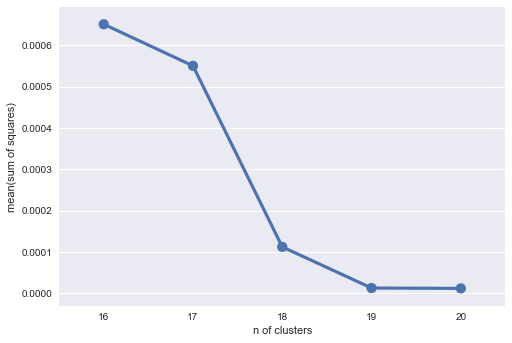

In [7]:
# Clustering - First step is to choose the number of cluster through the elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

tot_sum_of_sq = []

for j in range(n_components, n_components+5):
    kmeans = KMeans(n_clusters=j).fit(Aq)
    clusters_idx = kmeans.predict(Aq) # indices of which cluster each point belongs to
    centres = kmeans.cluster_centers_ 

    sum_of_squares = 0

    for i, item in enumerate(clusters_idx):
        dist = euclidean_distances(Aq[i].reshape(-1, 1), centres[item].reshape(-1, 1))[0][0]
        sum_of_squares = sum_of_squares + dist**2

    tot_sum_of_sq.append(sum_of_squares)

k_df = pd.DataFrame()
k_df['n of clusters'] = range(n_components, n_components+5)
k_df['sum of squares'] = tot_sum_of_sq
sns.pointplot(x="n of clusters", y="sum of squares", data=k_df)
plt.show()

In [8]:
# Choosing the number of clusters from the analysis above
n_clusters=18
kmeans = KMeans(n_clusters=n_clusters).fit(Aq)
clusters_idx = kmeans.predict(Aq) # indices of which cluster each point belongs to
centres = kmeans.cluster_centers_ 

In [9]:
# Obtaining the minimum distance between the points and the centre of the cluster, for each cluster
from sklearn.metrics.pairwise import euclidean_distances

# Dictionary where the cluster number is the key and the value is a list with the index of the point in Aq with 
# shortest distance to the centre and the actual distance
idx_short = {k:None for k in range(n_clusters)}

for i, item in enumerate(clusters_idx):
        dist = euclidean_distances(Aq[i].reshape(-1, 1), centres[item].reshape(-1, 1))[0][0]
        
        if (idx_short[item] == None):
            idx_short[item] = [i, dist]
        elif(dist < idx_short[item][1]):
            idx_short[item] = [i, dist]
            

In [10]:
# Making a list of the features to keep
idx_feat = []
for item in idx_short:
    idx_feat.append(idx_short[item][0])
print idx_feat

[11, 13, 40, 48, 5, 0, 20, 41, 12, 1, 3, 6, 2, 27, 34, 4, 19, 26]


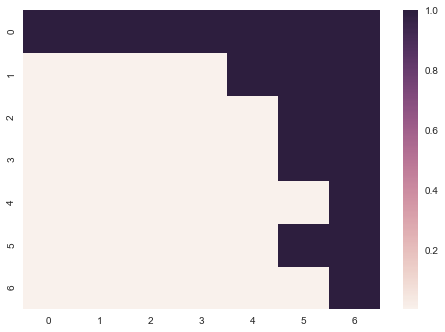

In [11]:
# The idx_min contains the list of indices of features to keep in the Coulomb matrix
# Visualising them
import numpy as np
cm = np.zeros((49))+0.001
for item in idx_feat:
    cm[item] = 1 
cm_sq = cm.reshape((7,7))
df = pd.DataFrame(cm_sq)
sns.heatmap(df)
plt.show()

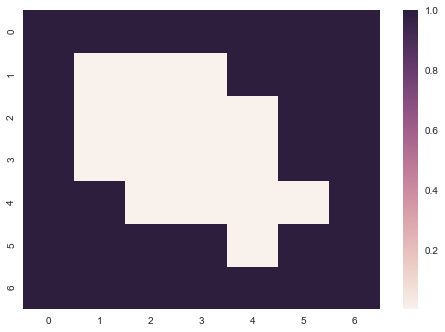

In [12]:
# Making the matrix diagonal
for i in range(7):
    for j in range(i,7):
        if (cm_sq[i][j] >= cm_sq[j][i]):
            cm_sq[j][i] = cm_sq[i][j]
        else:
            cm_sq[i][j] = cm_sq[j][i]
df_sq = pd.DataFrame(cm_sq)
sns.heatmap(df_sq)
plt.show()

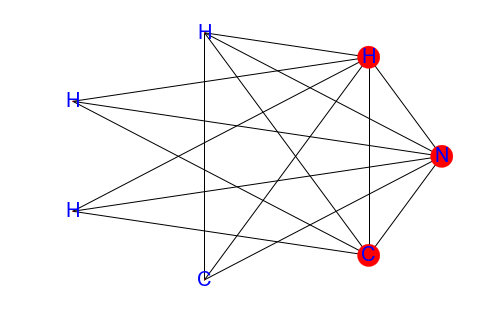

In [13]:
import networkx as nx
graph2 = nx.from_numpy_matrix(cm_sq, parallel_edges=False)
print graph2
pos = {}
for i in range(7):
    x_point = 0.6*np.cos((i+1)*2*np.pi/7)
    y_point = 0.6*np.sin((i+1)*2*np.pi/7)
    pos[i] = np.array([x_point, y_point])
labels = {}
labels[0] = 'H'
labels[1] = 'H'
labels[2] = 'H'
labels[3] = 'H'
labels[4] = 'C'
labels[5] = 'C'
labels[6] = 'N'
node_size = np.zeros(7)
for i in range(7):
    node_size[i] =  abs(graph2[i][i]['weight'])*500
nx.draw_networkx_nodes(graph2, pos, node_size=node_size)
nx.draw_networkx_labels(graph2, pos, labels=labels, font_size=20, font_family='sans-serif', font_color='blue')
# edges
edgewidth = [d['weight'] for (u, v, d) in graph2.edges(data=True)]
nx.draw_networkx_edges(graph2, pos, width=edgewidth)
plt.axis('off')
plt.show()